# EDIPI Workshop qgs tutorial - Part I: Computing the LLE

This notebook is the second one of a tutorial given during the EDIPI workshop at RMI in January 2023.
In this tutorial, you will learn:

1. How to install the [qgs](https://github.com/Climdyn/qgs) framework for low-order climate and weather modeling
2. How to run the model
3. **How to compute the Largest Lyapunov Exponent (LLE) in the model**
4. How to compute the full Lyapunov Exponent spectrum
5. How to compute the correlation properties of the underlying dynamical model

Here we will be concerned with task 3 above: learning how to compute the largest [Lyapunov exponent](https://en.wikipedia.org/wiki/Lyapunov_exponent) in the model.

We assume that you have already been through the [Introduction notebook](https://github.com/jodemaey/EDIPI-qgs-tutorial-on-predictability/blob/main/EDIPI%20workshop%20qgs%20tutorial%20-%20Introduction.ipynb), qgs and the tutorial being installed.

## Setup of the model

We use again the simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley), as in the Introduction notebook. But now, we are going to repeat a perturbation experiment to obtain the largest Lyapunov exponent. 

First, we need to load the model, and integrate it to find an initial condition on the attractor, as in the Introduction notebook:

### Modules import

First, load some modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Importing the model's modules

In [2]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [3]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

### Defining the model

First, we define some general parameters

In [4]:
# Time increment parameter
dt = 0.1
# Saving the model state every 5 steps
write_steps = 5

Now we create the model parameters object:

In [5]:
model_parameters = QgParams()

We set up some parameters:

In [6]:
# here we define the latitude to be 50 degrees and a predefined amplitude of the meridional temperature gradient
model_parameters.set_params({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd':0.045})

and indicate that we want an atmospheric channel for the atmosphere, with Fourier modes up to wavenumber 2 in each spatial direction:

In [7]:
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)

We also set some topography

In [8]:
model_parameters.ground_params.set_orography(0.2, 1)

and indicate the amplitude of the meridional temperature gradient which forces the model:

In [9]:
model_parameters.atemperature_params.set_thetas(0.1, 0)

and we are done configuring the model.

Finally, we create the tendencies $\boldsymbol{f}$ that will allow us to integrate the model equations:

In [10]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 6.66 s, sys: 766 ms, total: 7.43 s
Wall time: 6.71 s


### Time integration

We now integrate our model with the qgs built-in integrator:

In [11]:
integrator = RungeKuttaIntegrator()

We tell this integrator to use our defined model

In [12]:
integrator.set_func(f)

We can now start from a small random initial condition and integrate over a transient time to obtain an initial condition on the attractors

In [13]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)  # write_steps=0 will only give us the last step
time, ic = integrator.get_trajectories()

CPU times: user 19.9 ms, sys: 73.1 ms, total: 93 ms
Wall time: 10.5 s


and we are ready to start our exercise on the computation of the LLE.

## Exercice: Computing the LLE

In principle, to compute the LLE $\lambda$, we need to compute on point $\boldsymbol{x}$ of the attractor

$$ \lambda(\boldsymbol{x}, \boldsymbol{u}) = \lim_{t\to\infty} \lim_{\|\boldsymbol{\delta}_0\|\to 0} \frac{1}{t} \log \frac{\|\boldsymbol{\delta}_t\|}{\|\boldsymbol{\delta}_0\|} \qquad\qquad \mathrm{(1)}$$

where $\boldsymbol{\delta}_0 = \|\boldsymbol{\delta}_0\| \, \boldsymbol{u}$ with $\boldsymbol{u}$ the direction in the model *phase space* corresponding to the *maximum growth rate* of the perturbation in $\boldsymbol{u}$, i.e. the most unstable direction.

Computing approximately this formula is easy for an arbitrary vector $\boldsymbol{u}$ is easy. Just run 2 copies of the model with initial conditions $\boldsymbol{x}$ and $\boldsymbol{x} + \boldsymbol{\delta}_0$ and measure the distance between the two trajectories $\|\boldsymbol{\delta}_{\Delta t}\|$ after a time $\Delta t$. This is better represented by a picture (from Wikipedia ;-)
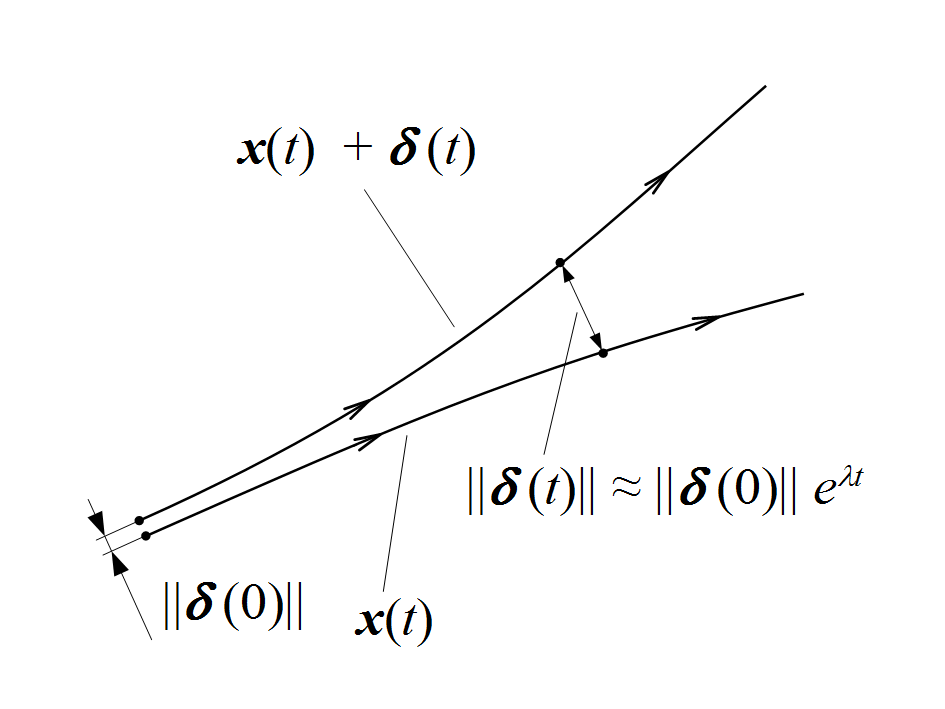
You can then compute the logarithm of the ratio in (1) and estimate the *local* lyapunov exponent
$$ \lambda^\mathrm{loc}(\boldsymbol{x}, \boldsymbol{u}) \approx \frac{1}{\Delta t} \log \frac{\|\boldsymbol{\delta}_{\Delta t}\|}{\|\boldsymbol{\delta}_0\|} \qquad\qquad \mathrm{(2)}$$
Note that in this case, this is an approximation, because in principle the time evolution of the perturbation $\boldsymbol{\delta}_t$ should have been computed with the tangent linear model, while here we are using the nonlinear system (but for the largest Lyapunov exponent, this is a good approximation). You can then repeat this perturbation experiment $N$ times with different points $\boldsymbol{x}_i$ on the attractor, and get the largest Lyapunov exponent as
$$ \lambda \approx \frac{1}{N} \sum_{i=1}^N \lambda^\mathrm{loc}(\boldsymbol{x}_i, \boldsymbol{u}) \qquad\qquad \mathrm{(3)}$$

The more experiments you perform, the best your estimate will become (however at some point you don't get much more precision by increasing $N$). Typically, you use the final point of the unperturbed trajectory of the previous experiment as the new initial point on the attractor.

**Anyway, the problem is that we still don't know how to define the direction corresponding to the largest Lyapunov exponent !** Thankfully, to find this direction, we can use the [Osedelet theorem](http://www.scholarpedia.org/article/Oseledets_theorem), which implies that over time, $\boldsymbol{\delta}_t$ will align more and more in the direction of the largest Lyapunov exponent. In consequence, we can make subsequent perturbation experiments **where the direction of the new initial perturbation** $\boldsymbol{\delta}_0$ **is given by the direction** $\boldsymbol{\delta}_t / \|\boldsymbol{\delta}_t\|$ **of the final perturbation of the previous experiments.** In addition, we must typically discard the first experiments because the process of this alignement of the perturbations with the direction of the of LLE takes some times to converge.

The inverse of the largest Lyapunov exponent define a timescale which is considered to be the timespan over which the system is predictible, i.e. the range over which the pertubations evolve linearly. This can be defined globally for the whole attractor, or locally, associated to the predictability of weather regimes.
 
In the following, we shall thus make a code which compute the local largest Lyapunov exponent at various points of the attractor, and plot this information on it. We shall also compute the average to obtain the largest Lyapunov exponent, and see if the system is chaotic.

This exercise session will be as follow:

1. First, a code snippet will show you how to make a perturbed and non-perturbed trajectories. You can use it to design your code at point 3.
2. Then, before even coding anything, it is recommended that you write a [pseudo-code](https://en.wikipedia.org/wiki/Pseudocode) to reflect about the steps needed to implement the experiments described above. 
3. Finally, you will implement the algorithm and plot the results.

Let's proceed:

### 1. How to implement perturbation experiments in qgs